In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import defaultdict, Counter
from konlpy.tag import Okt
from datetime import datetime
import os
from wordcloud import WordCloud

In [88]:
# ───────────── 설정 ─────────────
# rcParams['font.family'] = 'NanumSquare'
rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

DATA_DIR = "../01_데이터수집/data/제20대_대선_테마주/"
PAXNET_PATH = "../01_데이터수집/비정형데이터/faxnet_20/팍스넷_20대_대선_테마주_크롤링_20250627.csv"
POS_PATH = "../03_모델링/sentiment_dictionary/final_positive_dict.csv"
NEG_PATH = "../03_모델링/sentiment_dictionary/final_negative_dict.csv"

FIXED_START = datetime(2022, 2, 5)
FIXED_END = datetime(2022, 3, 16)

In [89]:
# ───────────── 데이터 로딩 ─────────────
df = pd.read_csv(PAXNET_PATH)
df["날짜"] = pd.to_datetime(df["날짜"])

positive_df = pd.read_csv(POS_PATH)
negative_df = pd.read_csv(NEG_PATH)
sentiment_dict = {
    **dict(zip(positive_df["단어"], positive_df["최종점수"])),
    **dict(zip(negative_df["단어"], negative_df["최종점수"]))
}

okt = Okt()

In [98]:
df

,종목명,날짜,시간,제목,댓글수,작성자,조회수,추천수,내용,URL
0,상지건설,2022-02-07,15:38:13,이번주 상한가 한번 쏘시나요??? 형님들 상지 너무 조용한데요..,0,나루랜드,6339,1,형님들 부탁 드립니다..,https://www.paxnet.co.kr/tbbs/view?id=042940&s...
1,덕성,2022-02-07,08:43:07,7일아침 방금 뜬 리얼미터 여론조사,0,김치녀,1082,1,께임 끝,https://www.paxnet.co.kr/tbbs/view?id=004830&s...
2,삼부토건,2022-02-08,11:43:48,김건희,1,쩜빵,438,1,윤썩관련주,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
3,삼부토건,2022-02-08,20:07:08,"합병된 무림페이퍼는 매출3조원,영업이익8천600억원,순이익8천500억원,친환경제품 ...",0,매쌓기투자자,368,0,"합병된 무림페이퍼는 매출3조원,영업이익8천600억원,순이익8천500억원,친환경제품 ...",https://www.paxnet.co.kr/tbbs/view?id=001470&s...
4,삼부토건,2022-02-08,22:52:07,삼부토건축상!9일~1/2차일부축소매도대기가격,0,코레나가,190,0,삼부토건1/2차고점매도가격 : 네이버 카페 (naver.com),https://www.paxnet.co.kr/tbbs/view?id=001470&s...
...,...,...,...,...,...,...,...,...,...,...
122,삼부토건,2022-03-14,10:25:21,윤석영당선자정책 원격진료수혜주 본겨부각 소프트렌!!!,1,jhuok,224,1,상최대향상 코로나세계1위확진 코로나총제적난국윤석열 정책 대장주\nhttps://m...,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
123,삼부토건,2022-03-14,10:32:35,인트로메딕 만지던 넘이 매수한 주식,0,k9동방불패,373,0,보유 작살,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
124,삼부토건,2022-03-14,15:06:08,서울대가뭉쳣다 ㆍ대표ㆍ회장 윤석열동문,0,참조쿤,278,0,250만호건설 도로ㆍ철도 지하화 ㆍ부지조성 ㆍ재개발 재건축 철거 수혜\n우크라이...,https://www.paxnet.co.kr/tbbs/view?id=001470&s...
125,덕성,2022-03-14,09:00:05,덕성우 떡상각,0,haru811,742,0,가격대 ㅠ,https://www.paxnet.co.kr/tbbs/view?id=004830&s...


In [90]:
# ───────────── 감성 점수 계산 함수 ─────────────
def compute_sentiment_by_date(df, stock_name, sentiment_dict, okt):
    score_by_date = defaultdict(float)
    for _, row in df[df["종목명"] == stock_name].iterrows():
        date = row["날짜"].date()
        text = f"{row['제목']} {row['내용']}"
        words = set(okt.morphs(text))
        score = sum(sentiment_dict[word] for word in words if word in sentiment_dict)
        score_by_date[date] += score
    return score_by_date


In [91]:
# ───────────── 종목별 감성 점수 및 주가 저장 ─────────────
all_stock_sentiment = {}
all_stock_prices = {}

for file_name in os.listdir(DATA_DIR):
    if not file_name.endswith(".csv"):
        continue

    file_path = os.path.join(DATA_DIR, file_name)
    price_df = pd.read_csv(file_path)
    price_df["Date"] = pd.to_datetime(price_df["Date"])
    price_df = price_df[(price_df["Date"] >= FIXED_START) & (price_df["Date"] <= FIXED_END)]

    if price_df.empty:
        continue

    stock_name = price_df["Name"].iloc[0]
    score_by_date = compute_sentiment_by_date(df, stock_name, sentiment_dict, okt)

    sentiment_df = pd.DataFrame({
        "날짜": pd.to_datetime(list(score_by_date.keys())),
        "감성점수": list(score_by_date.values())
    }).sort_values("날짜")

    all_stock_sentiment[stock_name] = sentiment_df
    all_stock_prices[stock_name] = price_df

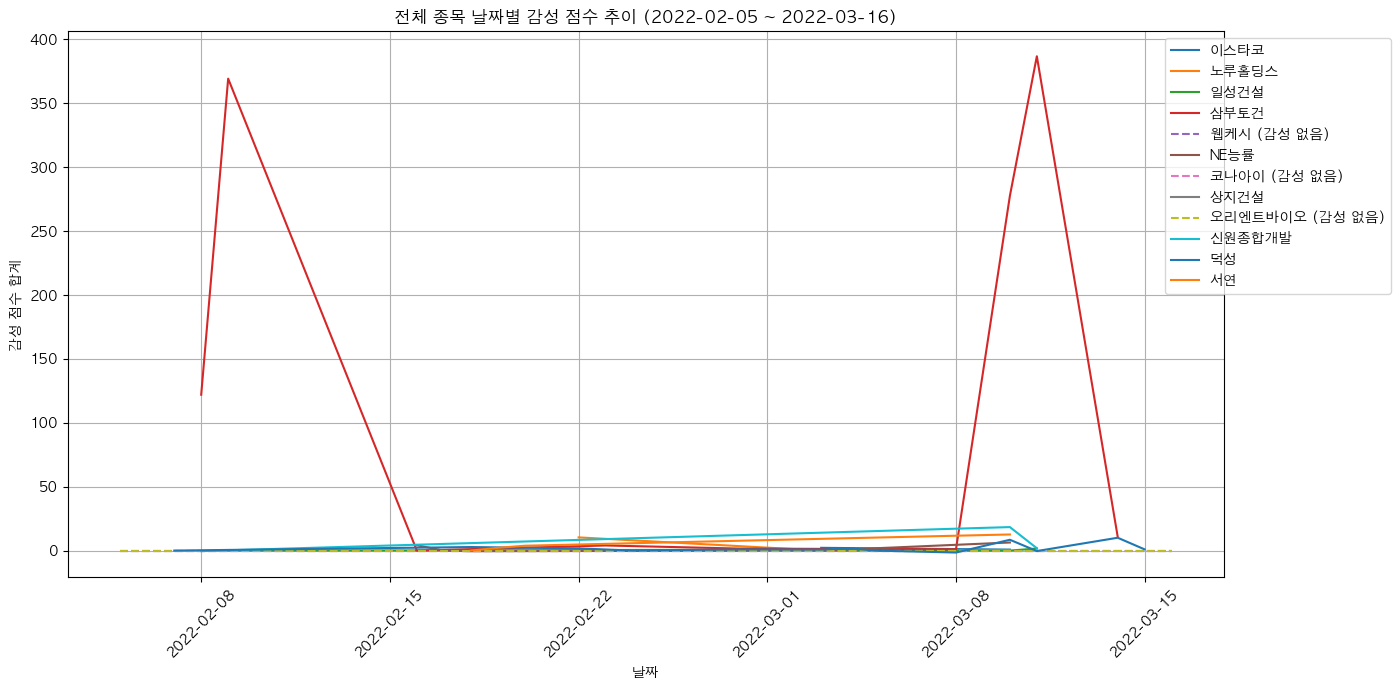

In [92]:
# ───────────── [1] 전체 종목 감성 점수 추이 ─────────────
plt.figure(figsize=(14, 7))

for stock, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]
    if filtered_sentiment.empty:
        # 날짜 축만 유지하고 y=0 값으로 대체
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', label=f"{stock} (감성 없음)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"], label=stock)

plt.title("전체 종목 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
plt.xlabel("날짜")
plt.ylabel("감성 점수 합계")
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

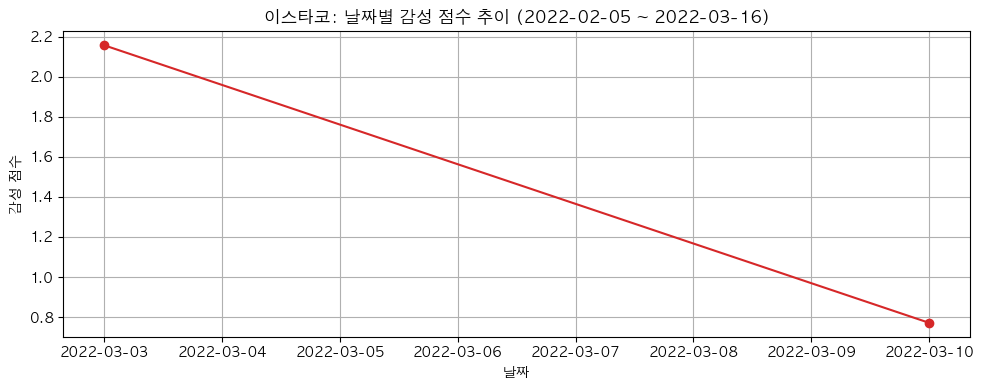

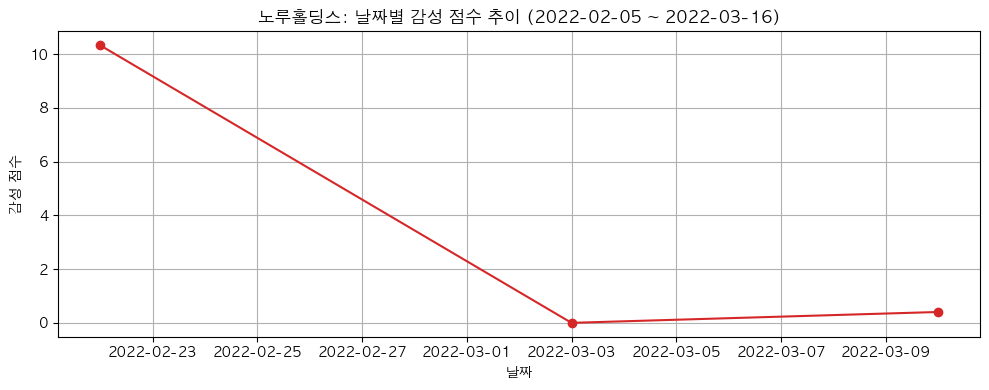

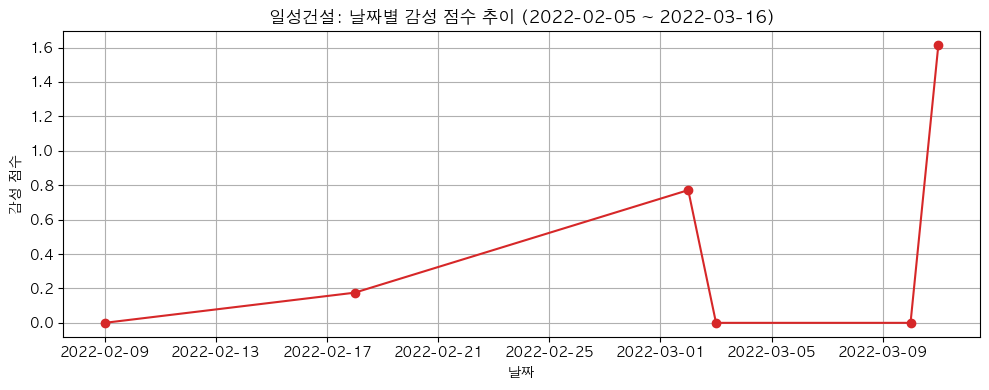

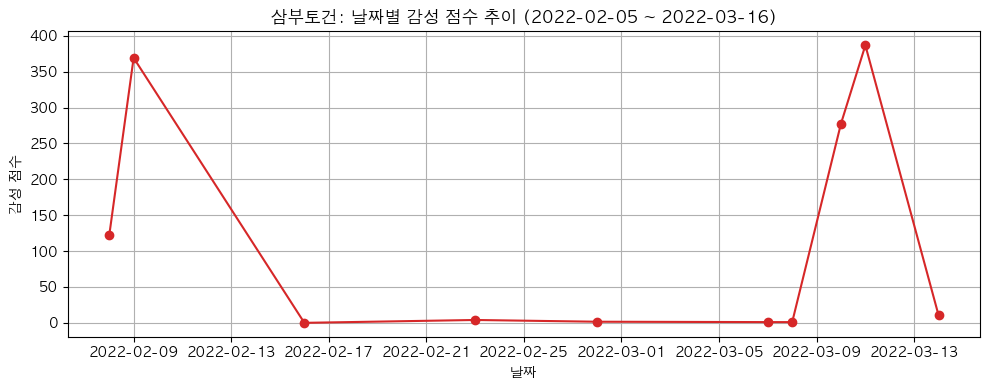

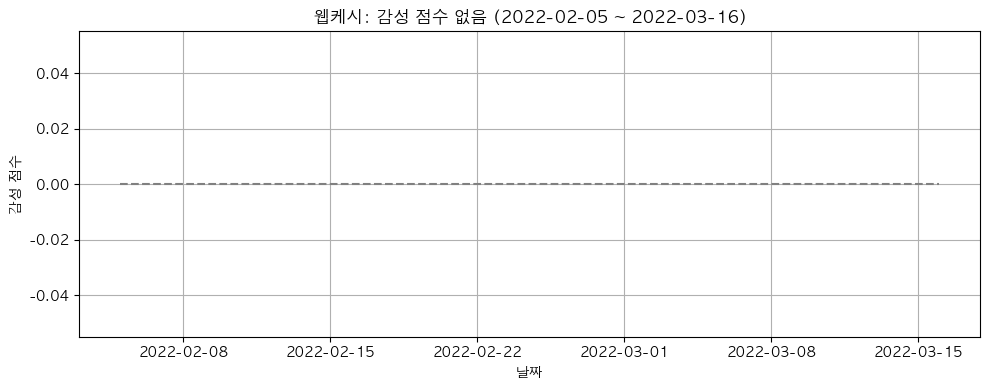

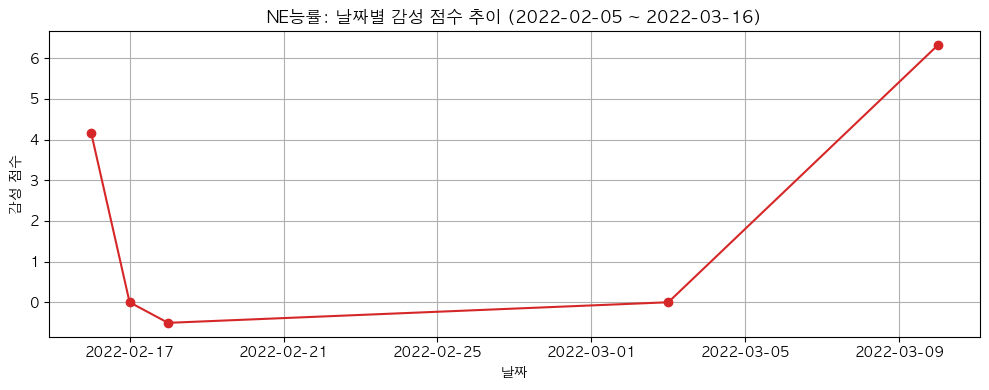

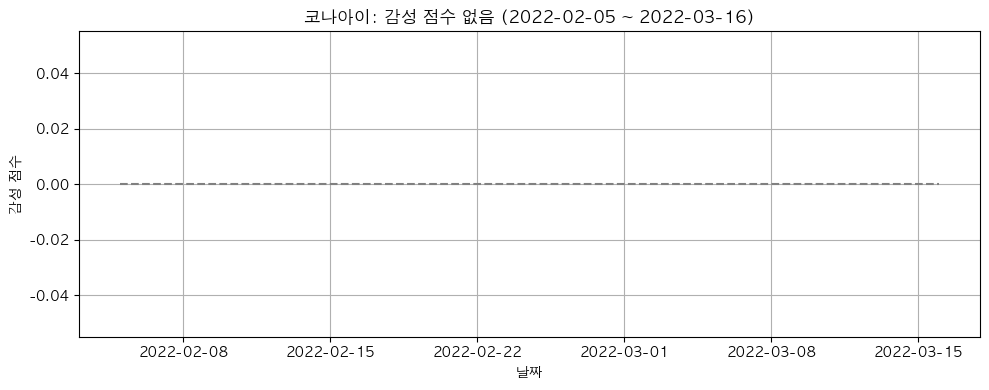

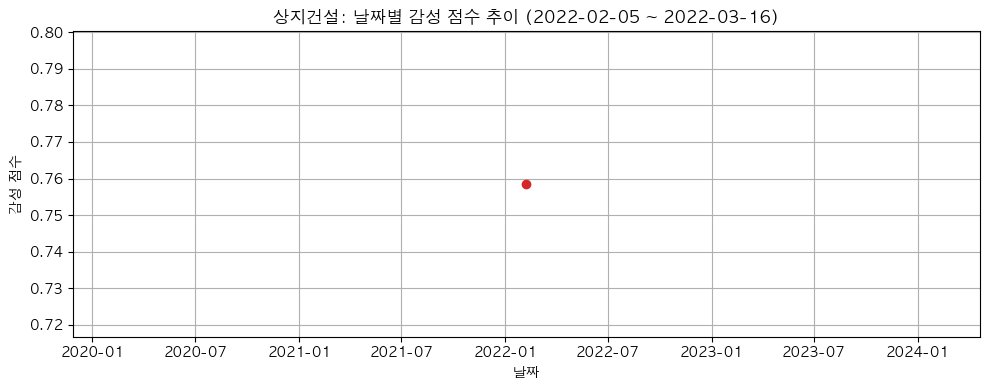

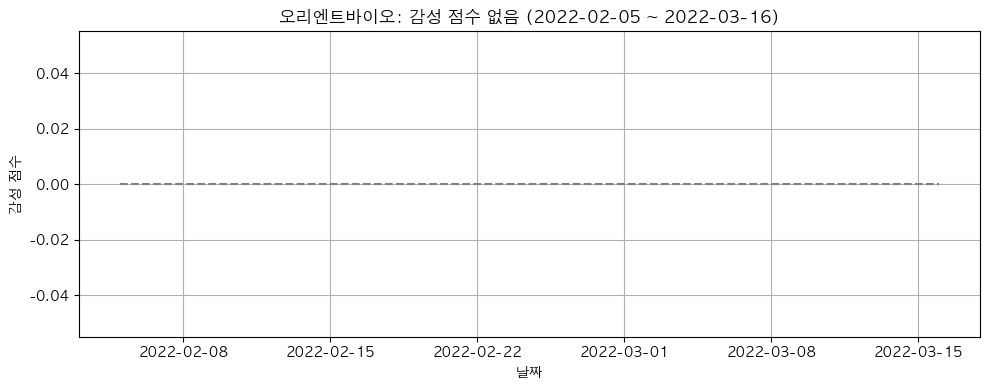

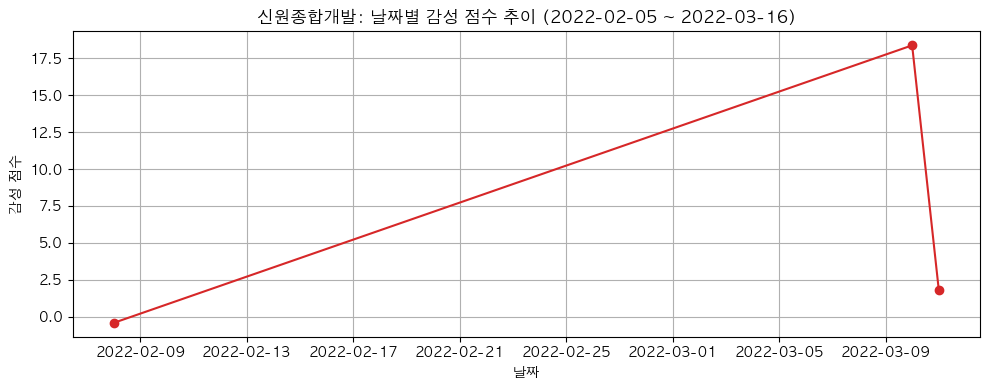

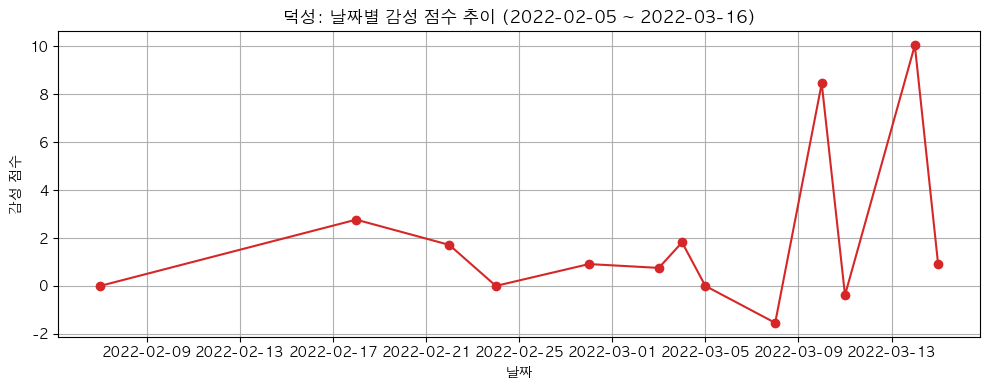

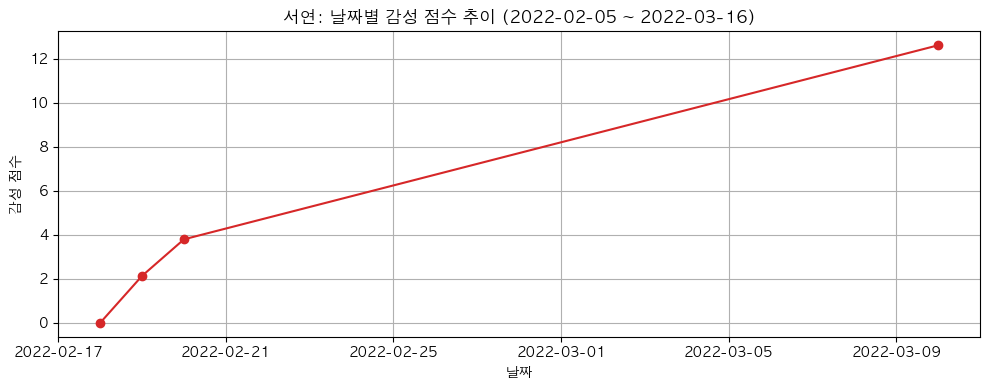

In [93]:
# ───────────── [2] 종목별 감성 점수만 시각화 ─────────────
for stock_name, sentiment_df in all_stock_sentiment.items():
    filtered_sentiment = sentiment_df[
        (sentiment_df["날짜"] >= FIXED_START) &
        (sentiment_df["날짜"] <= FIXED_END)
    ]

    plt.figure(figsize=(10, 4))
    if filtered_sentiment.empty:
        plt.plot([FIXED_START, FIXED_END], [0, 0], linestyle='--', color='gray')
        plt.title(f"{stock_name}: 감성 점수 없음 (2022-02-05 ~ 2022-03-16)")
    else:
        plt.plot(filtered_sentiment["날짜"], filtered_sentiment["감성점수"],
                 marker='o', color='tab:red')
        plt.title(f"{stock_name}: 날짜별 감성 점수 추이 (2022-02-05 ~ 2022-03-16)")
    plt.xlabel("날짜")
    plt.ylabel("감성 점수")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [95]:
# 총 기간은 2022-02-05 ~ 2022-03-16
# 포바이포(이재명 후보 테마주) 출력이 없음
# 확인해보니 종가 데이터 자체가 2022-04-26일부터 시작
# 따라서, 2022-02-05 ~ 2022-03-16 데이터 출력이 불가능함

/var/folders/x1/g6cgmw8x0b31zv5jcsxfxn880000gn/T/ipykernel_22030/1682697835.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})


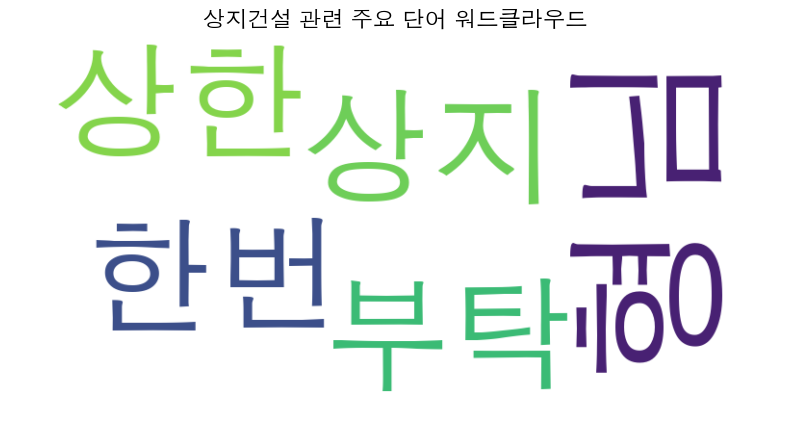

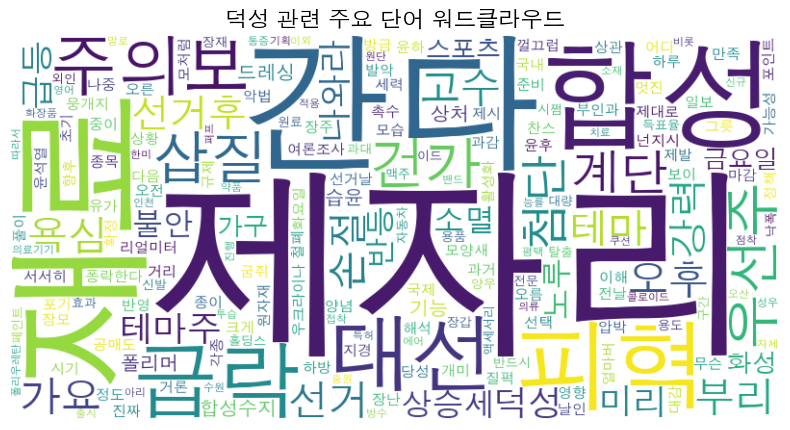

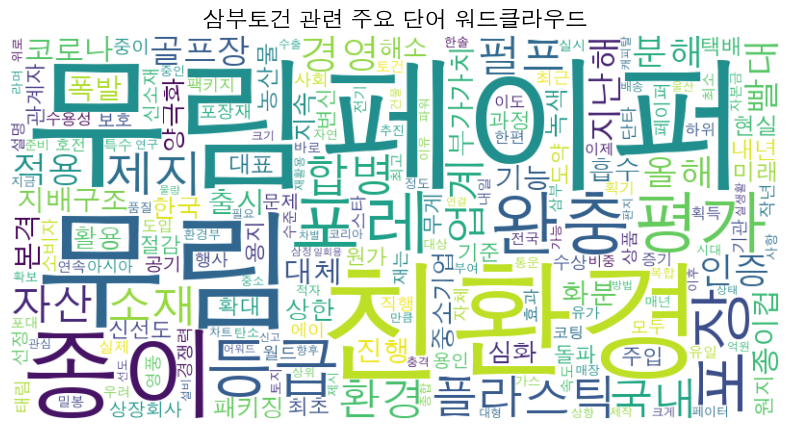

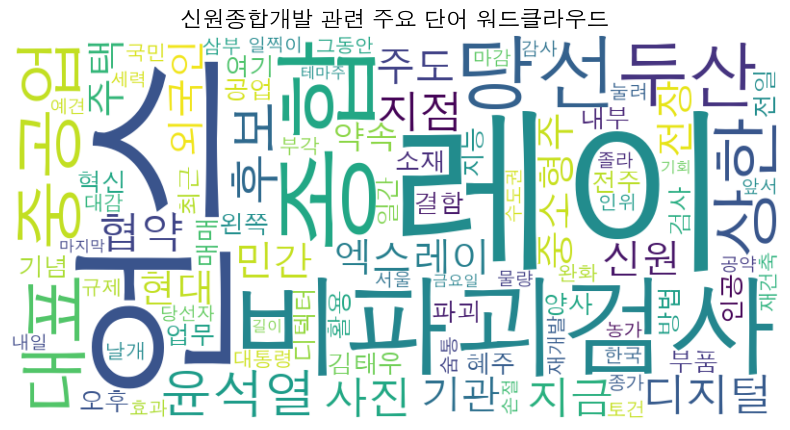

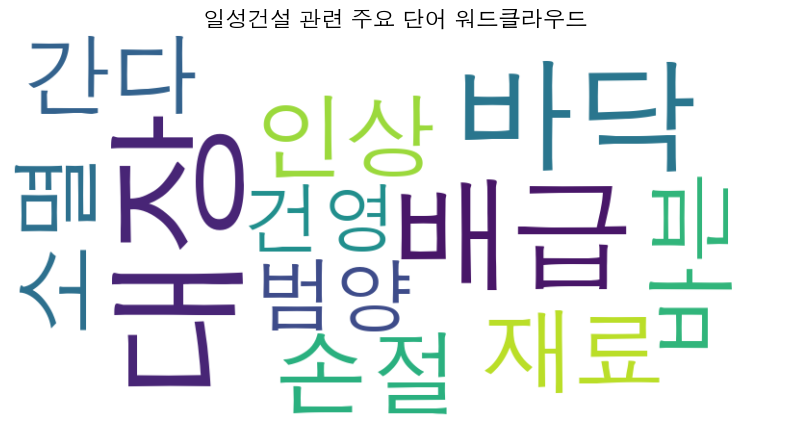

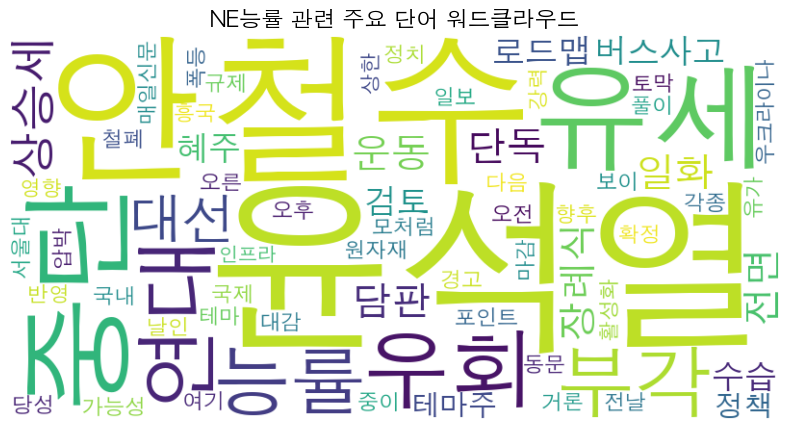

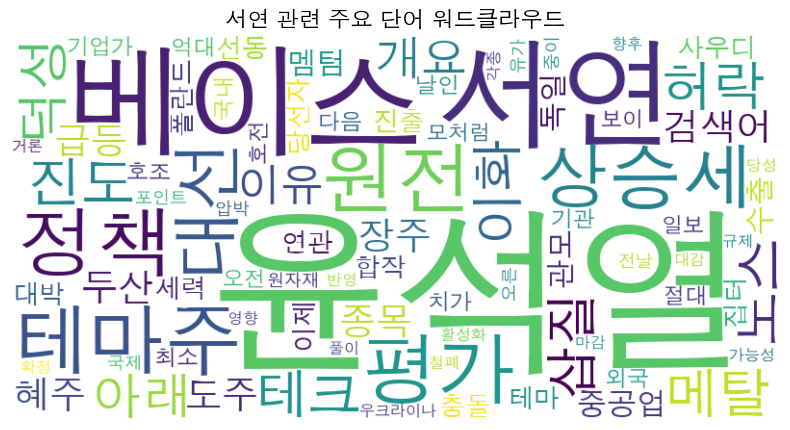

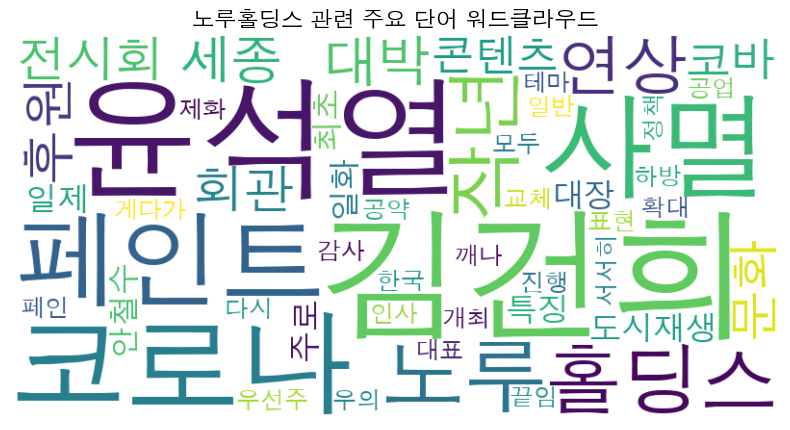

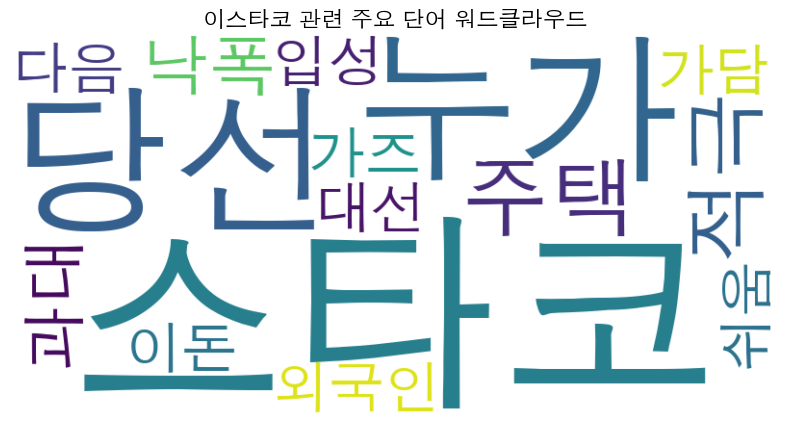

In [97]:
# 데이터 로드
df_finance_data = pd.read_csv("../01_데이터수집/data/finance_data.csv").drop_duplicates(subset=["kor_sentence"])
df_finance_data["labels"] = df_finance_data["labels"].replace({"neutral": 0, "positive": 1, "negative": 2})
texts = df_finance_data["kor_sentence"].tolist()

okt = Okt()

# 불용어 후보 생성 (상위 3% 빈도 단어 + 금융 특화)
all_words = []
for text in texts:
    tokens = okt.pos(text, stem=True)
    all_words.extend([w for w, pos in tokens if pos in ['Noun', 'Adjective', 'Verb'] and len(w) > 1])

counter = Counter(all_words)
top_k = int(len(counter) * 0.03)
high_freq_stopwords = set([w for w, _ in counter.most_common(top_k)])

# 금융 특화 불용어
financial_stopwords = {
    "시장", "주가", "증시", "투자", "매수", "매도", "주식", "증권", 
    "코스피", "코스닥", "기업", "경제", "금융", "지수", "수익", 
    "매출", "실적", "전망", "환율", "금리", "거래", "포트폴리오"
}

# 전체 불용어 세트
candidate_stopwords = high_freq_stopwords | financial_stopwords

def generate_wordcloud(df, stock_name, okt, candidate_stopwords):
    text_corpus = ""
    # 해당 종목의 게시글만 추출
    for _, row in df[df["종목명"] == stock_name].iterrows():
        text = f"{row['제목']} {row['내용']}"
        text_corpus += f" {text}"

    # 형태소 분석 (명사 추출)
    nouns = okt.nouns(text_corpus)
    # 불용어 제거
    filtered = [word for word in nouns if word not in candidate_stopwords and len(word) > 1]

    # 빈도 계산
    word_counts = Counter(filtered)
    if not word_counts:
        print(f"'{stock_name}'에 대해 충분한 텍스트가 없어 워드클라우드를 생성할 수 없습니다.")
        return

    # 워드클라우드 생성
    wc = WordCloud(
        font_path="/System/Library/Fonts/AppleGothic.ttf",  # macOS
        width=800, height=400,
        background_color="white"
    )
    wc.generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{stock_name} 관련 주요 단어 워드클라우드", fontsize=16)
    plt.show()

# 전체 종목에 대해 반복 수행
for stock_name in df["종목명"].unique():
    generate_wordcloud(df, stock_name, okt, candidate_stopwords)